**Mount google drive**

Put the notebook and the data in the same folder.

In [8]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/GPU_Final_Project


Mounted at /content/drive
/content/drive/MyDrive/GPU_Final_Project


**Visualization**

Number of element per class : 
  10
3      16
4     140
5    1185
6    1773
7     735
8     147
9       4
dtype: int64


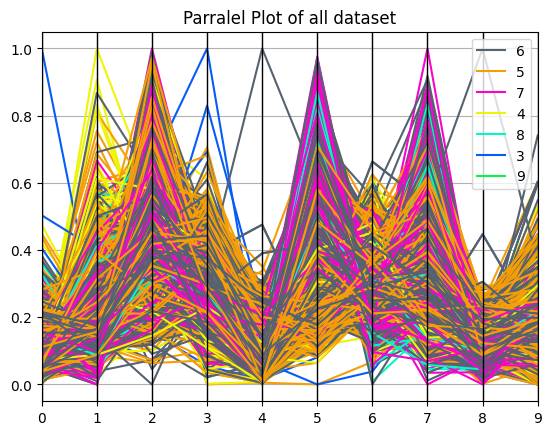

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import parallel_coordinates

data = pd.read_csv('MLoGPU_data1_train.csv', header=None)
data[10] = [int(i) for i in data[10]]

print('Number of element per class : \n ',data.groupby([10]).size())

parallel_coordinates(data[[0,1,2,3,4,5,6,7,8,9,10]], 10, color=("#556270", "#f59e07", "#f507c9","#edf507", "#05f5c5", "#055df5", "#05f549"))
plt.title("Parralel Plot of all dataset")
plt.show()


In [4]:
## Correlation plot
corr = data[[0,1,2,3,4,5,6,7,8,9]].corr()
corr.style.background_gradient(cmap='coolwarm')


,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.106774,0.001142,0.612310,0.290529,-0.254550,-0.053291,0.062494,0.288879,0.108110
1,-0.106774,1.000000,-0.032730,0.082490,0.072184,0.080102,-0.011520,-0.032853,0.029958,-0.153813
2,0.001142,-0.032730,1.000000,0.003579,-0.198457,0.123644,-0.431794,0.160742,-0.097337,-0.176151
3,0.612310,0.082490,0.003579,1.000000,0.398306,-0.451719,0.094905,0.135454,0.528384,0.134551
4,0.290529,0.072184,-0.198457,0.398306,1.000000,-0.443481,0.098554,-0.029254,0.838957,0.104900
5,-0.254550,0.080102,0.123644,-0.451719,-0.443481,1.000000,-0.123524,-0.017395,-0.774067,-0.088776
6,-0.053291,-0.011520,-0.431794,0.094905,0.098554,-0.123524,1.000000,-0.024982,0.272586,0.303101
7,0.062494,-0.032853,0.160742,0.135454,-0.029254,-0.017395,-0.024982,1.000000,0.071400,0.066105
8,0.288879,0.029958,-0.097337,0.528384,0.838957,-0.774067,0.272586,0.071400,1.000000,0.162334
9,0.108110,-0.153813,-0.176151,0.134551,0.104900,-0.088776,0.303101,0.066105,0.162334,1.000000


In [5]:
import cupy as cp

**Import Python library**

In [6]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import itertools

**Import python library for CUDA**

In [7]:
## Library
!pip install pycuda
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import math
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 12.5 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1-cp310-cp310-linux_x86_64.whl size=661204 sha256=df68c743e81db4dd819221eab8a4136bea95967de656cd802c16342d92a886ff
  Stored in directory: /root/.cache/pip/wheels/12/34/d2/9a349255a4eca3a486d82c79d21e138ce2ccd90f414d9d72b8
Successfully built pycuda


**Kernel CUDA for matrix operations**

This section contains two KERNEL modules. The inspirations are taken[texte du lien](https://) from GPU weekly assignments then add some modification in order to get the correct result.

**1. The function differenceSquared_modd** computes the squared value of the difference between two elements located in the same position in two different matrices.

**2. sumrows_modd** computes the sum of rows in a matrix.




In [19]:
  differenceSquared_modd = SourceModule("""
    __global__ void matrix_squared(const double* A, const double* B, double* C, int N, int M, int K)
    /*
    N - number of rows for A
    M - number of columns for A and number of rows for B
    K - number of columns for B
    */
      {
      int C_row = blockIdx.y * blockDim.y + threadIdx.y;
      int C_col = blockIdx.x * blockDim.x + threadIdx.x;

      //int i = threadIdx.x;
      //int j = threadIdx.y;
      //uint result = 0;

      if(C_row < N && C_col < K)
          {
          int C_index = K * C_row + C_col;
          double value = 0;
          value = A[C_index] - B[C_index];
          C[C_index] = value*value;
          }
    }
  """)

  sumrows_modd = SourceModule("""
    __global__ void RowSUM(const double* A, const double* B, double* C, int N, int M, int K)
        /*
        N - number of rows for A
        M - number of columns for A and number of rows for B
        K - number of columns for B
        */
          {
          int C_row = blockIdx.y * blockDim.y + threadIdx.y;
          int C_col = blockIdx.x * blockDim.x + threadIdx.x;

          if(C_row < N && C_col < K)
              {
              int C_index = K * C_row + C_col;
              double value = 0;
              for (int k = 0; k < M; k++)
                  {
                  int A_index = M * C_row + k;
                  int B_index = k * K + C_col;
                  //value = value + A[A_index] * B[B_index];
                  value = value+A[A_index] + B[A_index];
                  }
              C[C_index] = sqrt(value/2);
              }
            }
      """)

**Distance Vector**

This function computes the euclidian distance between one vector considered as a point and a matrix considered as set of point. The function take as **input** a vector and a matrix, then **return** a list of distance that corresponds to the distance of a point with respective to a set of point.

In [28]:
# Function distance
def distance_vector_matrix(Vect, Mat):
  #print('Vect shape :: ', type(Vect))
  #print('Mat shape :: ', type(Mat))

  A_n_rows = Mat.shape[0]
  A_n_cols = Vect.shape[0]
  B_n_rows = Mat.shape[0]
  B_n_cols = Mat.shape[1]

  #A_n_rows = 3
  #A_n_cols = 3
  #B_n_rows = 3
  #B_n_cols = 3
  value_type = float

  # C_n_rows = A_n_rows
  C_n_rows = B_n_rows
  C_n_cols = B_n_cols

  ############################ Threadblocks
  numThreadsPerBlock = 32
  numBlocksx = math.ceil(C_n_cols/numThreadsPerBlock)
  numBlocksy = math.ceil(C_n_rows/numThreadsPerBlock)

  # Prepare the input matrix for Kernel CUDA.
  # we duplicate Vect to form a square matrix in the same size as Mat.
  #A = np.random.randn(A_n_rows,A_n_cols)
  A = cp.array(B_n_rows*[Vect])
  A = A.astype(value_type)

  B = Mat
  B = B.astype(value_type)
  #print('A :: ',A.shape)
  #print('B :: ',B.shape)

  ############################ Allocate the memory on the GPU and copy the matrices.
  A_gpu = cuda.mem_alloc(A.size * A.dtype.itemsize)
  cuda.memcpy_htod(A_gpu, cp.asnumpy(A))

  B_gpu = cuda.mem_alloc(B.size * B.dtype.itemsize)
  cuda.memcpy_htod(B_gpu, cp.asnumpy(B))

  # Call the CUDA kernel.
  ############################ Square Matrix
  C = np.zeros([C_n_rows,C_n_cols])
  C = C.astype(value_type)
  C_gpu = cuda.mem_alloc(C.size * C.dtype.itemsize)

  # Difference between vector and matrix
  matrix_squared = differenceSquared_modd.get_function("matrix_squared")
  matrix_squared(A_gpu, B_gpu, C_gpu, np.int32(B_n_rows), np.int32(A_n_cols), np.int32(B_n_cols),
                           block=(numThreadsPerBlock, numThreadsPerBlock, 1),
                           grid=(numBlocksx, numBlocksy, 1))
  # Copy the result back to the host.
  cuda.memcpy_dtoh(C, C_gpu)

  ############################ SUM Row Matrix

  D = np.zeros([C_n_rows,C_n_cols])
  D = D.astype(value_type)
  D_gpu = cuda.mem_alloc(D.size * D.dtype.itemsize)

  n = C_n_rows
  m = C_n_rows
  k = C_n_rows
  # Compute sum of rows
  RowSUM = sumrows_modd.get_function("RowSUM")
  RowSUM(C_gpu, C_gpu, D_gpu, np.int32(A_n_rows), np.int32(A_n_cols), np.int32(B_n_cols),
                        block=(numThreadsPerBlock, numThreadsPerBlock, 1),
                        grid=(numBlocksx, numBlocksy, 1))

  ############################ Comparison CPU value & GPU value
  # Copy the result back to the host.
  cuda.memcpy_dtoh(D, D_gpu)

  # Do same calculation in CPU.
  C_cpu = np.square(A-B)
  C_cpu_sum = np.sqrt(np.sum(C_cpu, axis=1))

  # Verify the result
  #print('Squared Matrix value : ', np.allclose(C_cpu,C, 0.001,0.001))
  #print('C CPU squared    :: \n', C_cpu)
  #print('C GPU squared    :: \n', C)

  #print('Row Matrix sum       : ', np.allclose(C_cpu_sum,D[:,1], 0.001,0.001))
  #print('C CPU Sum      :: \n', C_cpu_sum)
  #print('C GPU Sum      :: \n', D[:,1])

  return D[:,1]

**KNN Predict**

This function takes the below inputs :

1. X_train : as reference data or a set of point.
2. y_train : as class label reference for the majority vote.
3. X_test  : where each is considered as a vector and used to compute the distance between a vector and a matrix.
4. k : number of neighbor to take

then computes the distance between a vector and a matrix then gives the best class for the vector according to the number of neighboor.



In [29]:
# Function to predict labels using kNN
def kNN_predict(X_train, y_train, X_test, k):
    predictions = []
    for test_point in X_test:
        # print(test_point)

        # Compute distances between test point and all training points
        #distances = euclidean_distance(test_point, X_train)
        distances = distance_vector_matrix(test_point, X_train)
        #print('Euclidian               :: ',distances)
        #print('Distance Vect to Matrix :: ',dist)

        # Get indices of k nearest neighbors
        nearest_indices = cp.argsort(distances, axis=-1)[:k]

        # Get labels of k nearest neighbors
        nearest_labels = y_train[nearest_indices]

        # Predict the label by majority vote
        predicted_label = cp.bincount(nearest_labels).argmax()
        predictions.append(predicted_label)
    return cp.array(predictions)

# Euclidian distance for validation purpose only
def euclidean_distance(x1, x2):
    # return cp.linalg.norm(x1 - x2)
    return cp.sqrt(((x1 - x2)**2).sum(axis=1))

**Data preprocessing 1**

This function do the following tasks :
1. Separate the class label from the whole dataset
2. Split the dataset into  train and test data.
3. Convert type into cupy array
4. No normalization

In [35]:
def preprocessing(data):
  # Extract features and labels
  X = data[:, :-1]  # Features
  y = data[:, -1]   # Labels

  # Convert labels to integer type if not already
  y = y.astype(int)

  # Split the data into training and testing sets (80% train, 20% test)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  # Convert data to CuPy arrays for GPU computation
  X_train_cp = cp.array(X_train)
  X_test_cp = cp.array(X_test)
  y_train_cp = cp.array(y_train)

  return X_train_cp, X_test_cp, y_train_cp, y_test

**Data processing 2**

This function do the same tasks in data processing 1 with normalization.

In [53]:
def preprocessing_norm(data):
  # Extract features and labels
  X = data[:, :-1]  # Features
  y = data[:, -1]   # Labels

  # Convert labels to integer type if not already
  y = y.astype(int)

  # Split the data into training and testing sets (80% train, 20% test)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  # Compute the mean and std value of the train datastet
  x_mean = cp.mean(X_train,axis=0)
  x_std = cp.std(X_train,axis=0)

  X_train_norm = (X_train - x_mean)/x_std
  X_test_norm = (X_test - x_mean)/x_std

  # Convert data to CuPy arrays for GPU computation
  X_train_cp = cp.array(X_train_norm)
  X_test_cp = cp.array(X_test_norm)
  y_train_cp = cp.array(y_train)

  return X_train_cp, X_test_cp, y_train_cp, y_test

**Training**

In this cell, various value of k as number of neighbour are used during the training and the accuracy and the GPU time execution for each k is also provided.

In [55]:
#Prepocess the data
X_train_norm, X_test_norm, y_train_cp, y_test = preprocessing_norm(data)
X_train_cp, X_test_cp, y_train_cp, y_test     = preprocessing(data)

# The number of neighborhood
print('----------------------- Training without normalization')
list_neighbor = [1, 2, 3, 4, 5, 6, 7]
for k in list_neighbor:
  start_time = time.time()
  predictions_gpu = kNN_predict(X_train_cp, y_train_cp, X_test_cp, k)
  end_time = time.time()
  gpu_time = end_time - start_time

  # Convert predictions from CuPy to NumPy for evaluation
  predictions_np = cp.asnumpy(predictions_gpu)

  # Evaluate accuracy
  accuracy = accuracy_score(y_test, predictions_np)
  conf_mat = confusion_matrix(y_test, predictions_np)
  print("For k : ",k," Accuracy:", round(accuracy*100,3)," GPU execution time:", gpu_time)
  # print(classification_report(y_test, predictions_np))

#Stable Accuracy (1,5,6,)
#Accuracy + Time Execution (1, 2, 5)
#Normalization reduce the model's performance

print('\n\n\n----------------------- Training with normalization')
list_neighbor = [1, 2, 3, 4, 5, 6, 7]
for k in list_neighbor:
  start_time = time.time()
  predictions_gpu = kNN_predict(X_train_norm, y_train_cp, X_test_norm, k)
  end_time = time.time()
  gpu_time = end_time - start_time

  # Convert predictions from CuPy to NumPy for evaluation
  predictions_np = cp.asnumpy(predictions_gpu)

  # Evaluate accuracy
  accuracy = accuracy_score(y_test, predictions_np)
  conf_mat = confusion_matrix(y_test, predictions_np)
  print("For k : ",k," Accuracy:", round(accuracy*100,3)," GPU execution time:", gpu_time)
  # print(classification_report(y_test, predictions_np))


----------------------- Training without normalization


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


For k :  1  Accuracy: 57.8  GPU execution time: 4.276834726333618


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


For k :  2  Accuracy: 53.8  GPU execution time: 4.390589714050293


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


For k :  3  Accuracy: 53.5  GPU execution time: 3.817288637161255


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


For k :  4  Accuracy: 52.9  GPU execution time: 3.787473678588867


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


For k :  5  Accuracy: 55.2  GPU execution time: 4.768263816833496


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


For k :  6  Accuracy: 54.5  GPU execution time: 3.72981595993042


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


For k :  7  Accuracy: 52.0  GPU execution time: 3.750605583190918



----------------------- Training with normalization


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


For k :  1  Accuracy: 59.4  GPU execution time: 5.001473426818848


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


For k :  2  Accuracy: 56.2  GPU execution time: 3.914613723754883
For k :  3  Accuracy: 52.7  GPU execution time: 4.945672988891602


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


For k :  4  Accuracy: 52.0  GPU execution time: 4.816519260406494


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


For k :  5  Accuracy: 54.7  GPU execution time: 3.934420108795166


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


For k :  6  Accuracy: 53.0  GPU execution time: 3.7377092838287354


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


For k :  7  Accuracy: 54.9  GPU execution time: 5.035306215286255


**Best value**

There is significative difference between normalized or not normalizated dataset in the accuracy.

This section shows more details about the best **k** for the model for normalized dataset.


In [56]:
list_neighbor = [1, 2, 5]
# k=3 # set the number of neighboor
for k in list_neighbor:
  start_time = time.time()
  predictions_gpu = kNN_predict(X_train_norm, y_train_cp, X_test_norm, k)
  end_time = time.time()
  gpu_time = end_time - start_time

  # Convert predictions from CuPy to NumPy for evaluation
  predictions_np = cp.asnumpy(predictions_gpu)

  # Evaluate accuracy
  accuracy = accuracy_score(y_test, predictions_np)
  conf_mat = confusion_matrix(y_test, predictions_np)
  print("For k : ",k," Accuracy:", round(accuracy*100,3)," GPU execution time:", gpu_time)
  print(classification_report(y_test, predictions_np))


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


For k :  1  Accuracy: 59.4  GPU execution time: 4.236501693725586
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.29      0.25      0.27        28
           5       0.63      0.61      0.62       290
           6       0.63      0.67      0.65       461
           7       0.53      0.51      0.52       180
           8       0.33      0.26      0.29        39
           9       0.00      0.00      0.00         1

    accuracy                           0.59      1000
   macro avg       0.34      0.33      0.34      1000
weighted avg       0.59      0.59      0.59      1000



/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


For k :  2  Accuracy: 56.2  GPU execution time: 3.781371593475342
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.28      0.50      0.36        28
           5       0.52      0.72      0.61       290
           6       0.62      0.58      0.60       461
           7       0.63      0.37      0.47       180
           8       0.50      0.10      0.17        39
           9       0.00      0.00      0.00         1

    accuracy                           0.56      1000
   macro avg       0.36      0.33      0.31      1000
weighted avg       0.58      0.56      0.55      1000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd

For k :  5  Accuracy: 54.7  GPU execution time: 4.080352783203125
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.23      0.21      0.22        28
           5       0.54      0.62      0.58       290
           6       0.59      0.62      0.60       461
           7       0.49      0.39      0.44       180
           8       0.36      0.10      0.16        39
           9       0.00      0.00      0.00         1

    accuracy                           0.55      1000
   macro avg       0.32      0.28      0.29      1000
weighted avg       0.54      0.55      0.54      1000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
